Deep Neural Network approach to the downstream tracking.
====================

The baseline to beat
* BDT 0.80457111174771212 
* Logistic Regresion 0.76763467806915342
-------------

In [1]:
import random
gpuid = random.randint(0,3)
import os
print "random GPU roll: ",gpuid
os.environ["THEANO_FLAGS"]="device=gpu%i"%gpuid

random GPU roll:  2


Get the cutting-edge version of lasagne to enable BatchNormLayer. Have to be done only once. 
Need to update the requiements file. 

In [2]:
import root_numpy
import pandas as pd
import numpy
import numpy as np
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.preprocessing import PolynomialFeatures
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.learning_curve import validation_curve

import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer, batch_norm, dropout

import time

Welcome to JupyROOT 6.07/07


WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu2 is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [3]:
root_file = ROOT.TFile("datasets/Brunel_test_30kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [4]:
def replace_transforamtion(data):
    #abs transformation
    out = data
    out["seed_x"]=numpy.abs(data['seed_x'])
    out["seed_y"]=numpy.abs(data['seed_y'])
    out["seed_tx"]=numpy.abs(data['seed_tx'])
    out["seed_ty"]=numpy.abs(data['seed_ty'])
    #log transformation
    out["seed_p"]= numpy.log(data['seed_p'])
    out["seed_pt"]= numpy.log(data['seed_pt'])
    return out

In [5]:
data = replace_transforamtion(data)
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)
features.head()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,1.213708,7.841285,7.079410,25.0,0.0,12.0,1263.157617,517.249191,0.524220,0.061572
1,1.346112,7.930741,7.093734,25.0,0.0,12.0,1264.522435,99.363473,0.480288,0.009081
2,1.627632,8.469986,7.443378,25.0,0.0,12.0,1521.093160,196.064807,0.382802,0.025975
3,1.789231,8.556975,7.508752,25.0,0.0,12.0,1563.145597,483.850246,0.369674,0.058753
4,1.269238,7.741082,7.132965,24.0,0.0,12.0,1641.727752,411.084316,0.646627,0.054980


Print the features
-------------------------

In [6]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06,2.820225e+06
mean,2.151541e+00,8.832627e+00,7.059373e+00,1.778696e+01,2.583371e+00,1.116850e+01,5.329296e+02,3.792155e+02,2.452544e-01,5.047799e-02
std,1.450411e+00,1.058556e+00,5.334005e-01,4.672981e+00,4.624577e+00,1.080491e+00,4.467357e+02,4.158186e+02,2.053685e-01,5.301402e-02
min,2.503011e-04,7.014427e+00,5.664902e-01,8.000000e+00,0.000000e+00,8.000000e+00,1.936797e-04,8.009404e-04,4.877929e-07,1.786139e-09
25%,1.053873e+00,8.011151e+00,6.837125e+00,1.300000e+01,0.000000e+00,1.100000e+01,1.680454e+02,9.086889e+01,7.756509e-02,1.284370e-02
50%,1.714204e+00,8.656816e+00,7.024174e+00,1.900000e+01,0.000000e+00,1.200000e+01,3.975971e+02,2.159103e+02,1.848496e-01,3.124117e-02
75%,2.949078e+00,9.487110e+00,7.223235e+00,2.200000e+01,4.000000e+00,1.200000e+01,8.020341e+02,5.185574e+02,3.700550e-01,6.991058e-02
max,8.999829e+00,2.212160e+01,1.893711e+01,3.200000e+01,2.300000e+01,1.200000e+01,2.505840e+03,2.277240e+03,1.358254e+00,1.225459e+00


In [7]:
def print_features_histograms(Xdata, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(Xdata):
        # add sub plot on our figure
        ax = fig.add_subplot(Xdata.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(Xdata[feature], [1, 99])
        ax.hist(Xdata.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(Xdata.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

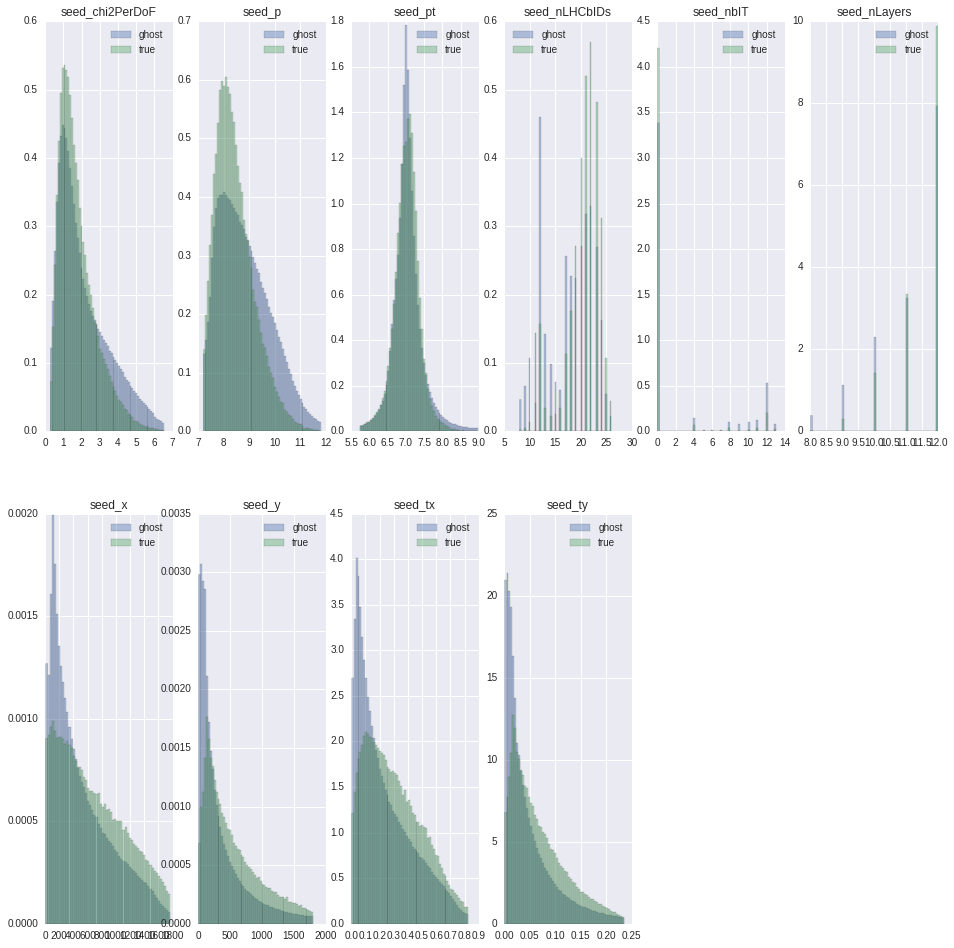

In [8]:
print_features_histograms(features, target)

In [20]:
data_scaled = StandardScaler().fit_transform(features)
scaled_features = pd.DataFrame(data_scaled)

Training of the basic version of the Deep Neural Network
=======================
I take a simple NN with 3 hidden layers:
* Layers must contain 500 hidden units each
* Layers must use tanh nonlinearity
* dropout probablilty set to 3

structure can be farther optimized, so feel free to experiment after you got it working

Split data into train and validation sets
----------------------

In [21]:
y = data['is_true_seed'].values==1
X = scaled_features[scaled_features.columns[1:]].values.astype(theano.config.floatX)

In [22]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=11, train_size=0.5)

In [23]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

Build the NN architecture
--------------------------

In [25]:
n_features = len(scaled_features.columns.values)-1
n_hid = 500
p_drop = 0.2

In [26]:
l_in = InputLayer([None, n_features],input_X,'input layer')

l_0 = lasagne.layers.BatchNormLayer(l_in, name="l_0")

l_1 = batch_norm(DenseLayer(l_0,
                num_units=n_hid,
                name='dense0',
                nonlinearity=lasagne.nonlinearities.tanh))

d_1 = dropout(l_1, p=p_drop)

l_2 = batch_norm(DenseLayer(d_1,
                num_units=n_hid,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh))

d_2 = dropout(l_2, p=p_drop)

l_3 = batch_norm(DenseLayer(d_2,
                num_units=n_hid,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh))

nn = DenseLayer(l_3,num_units=2,
                name='dense_out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [27]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[l_0.beta,
 l_0.gamma,
 dense0.W,
 dense0_bn.beta,
 dense0_bn.gamma,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense_out.W,
 dense_out.b]

In [28]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [29]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

In [30]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])

training loop
--------------

In [31]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [32]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

In [33]:
num_epochs = 10
batch_size = 1000
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    print ("start epoch %d"%epoch)
    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
        
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)


    # And a full pass over the validation data:
    val_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    val_batches = 0
    
    for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err, y_pred = val_fun(inputs, targets)
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        val_err += err
        val_batches += 1

    Ypred_val = np.concatenate(Ypred_batches)
    Ytrue_val = np.concatenate(Ytrue_batches)
    val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
    val_auc = roc_auc_score(Ytrue_val, Ypred_val)
    
    val_acc_curve.append(val_acc)
    val_auc_curve.append(val_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc  * 100))
    print("  validation AUCscore:\t\t{:.2f} %".format(
        val_auc * 100))

KeyboardInterrupt: 

start epoch 0
